<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Lab_Ricky/Lab3/GradientFreeOpt_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises: parameter estimation

In this exercise we will employ some optimization methods to identify unknown model parameters from available data.

Date: 2025

Course: Scientific computing tools for advanced mathematical modelling.

For further details on gradient free optimizers see this [app](https://simonblanke-optimization-tutori-optimization-tutorialapp-uxm0hr.streamlit.app)

In [40]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# The problem

The forward map is given by:

$ F(x,y;\mu_1, \mu_2) = (x-\mu_1)^2 + (y-\mu_2)^2 + \sin(0.5 \mu_1 \pi y) + \sin(0.5 \mu_2 \pi x)   $.

Let us consider as measurable outputs some pointwise measurement of F in 5 points:

$ y_i = F(x_i,y_i)  \text{    for } i=0,\ldots,4 $.


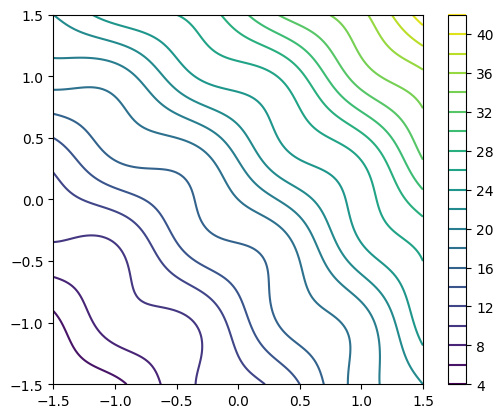

In [41]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,151), np.linspace(-1.5,1.5,151))

mu_1 = -3
mu_2 = -3

F = ((X-mu_1)**2) + ((Y-mu_2)**2)  + np.sin(((mu_1)/2)*np.pi*Y)*np.sin(((mu_2)/2)*np.pi*X)

plt.contour(X, Y, F , 20)
#plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(activation_time) )
plt.gca().set_aspect(1)
plt.colorbar()


Task 1: implement a function that map the input $\mu$ into the outputs $y_h(\mu)$ previously described.
Use the following signature:

In [42]:
def inputOutput(mu_1,mu_2, X_p = X, Y_p = Y):

    ind_list = [(75, 75), (25, 25), (25, 100), (100, 25), (100, 100)]

    y_out = np.zeros(5)

    for i in range(5):
      y_out[i] = ((X[0, ind_list[i][0]]-mu_1)**2) + ((Y[ind_list[i][1], 0]-mu_2)**2)  + np.sin(((mu_1)/2)*np.pi*Y[ind_list[i][1], 0])*np.sin(((mu_2)/2)*np.pi*X[0, ind_list[i][0]])

    return y_out

In [43]:
# test your code
print( inputOutput(3,3) )

[18.         33.         22.95710678 22.95710678 13.        ]



Suppose that during an experiment, the following timings are measured $y^* = [5.0, 13.0, 6.25, 8.25, 3.2071067811865475]$.

Task 2: construct a cost functional based on the mean squared error between $y$ and $y^*$. Use the following signature:

In [51]:
def CostFunctional(muval,ystar=[5.0, 13.0, 6.25, 8.25, 3.2071067811865475]):

    y_out = inputOutput(muval[0], muval[1])

    J = np.sqrt(np.mean((ystar - y_out) ** 2))
    return J

In [46]:
# test
print( CostFunctional([0,0]) )

6.74282473633634



Task 3: visualize the cost functional on a uniform grid in the parameter space $(-3,3)\times(-3,3)$.

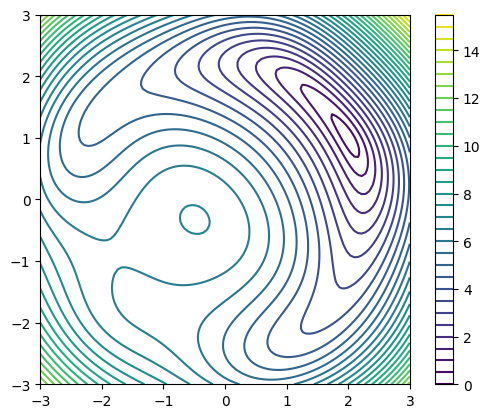

In [47]:
# TO DO
mu1v, mu2v = np.meshgrid(np.linspace(-3,3,101), np.linspace(-3,3,101))

J_vec = np.zeros((101, 101))

for i in range(101):
  for j in range(101):
    J_vec[i][j] = CostFunctional((mu1v[0, i], mu2v[j, 0]))

plt.contour(mu1v, mu2v, J_vec , 30)
plt.gca().set_aspect(1)
plt.colorbar()

# Gradient free methods

Family of optimization method (also known as black box methods), that does not require the gradient of the cost functional to find an estimate of the minimum.

# Random search method

The algorithm is summarized below.

 0. Initialize $\hat{\mu}$ with a random position in the set of admissible parameters.
 1. Until a termination criterion is met (number of iterations performed and accuracy measured by the cost functional), repeat the following steps:
  a. Sample randomly a new parameter ${\mu}_{guess}$ in a small interval of the current parameter $\hat{\mu}$,
  b. If $J({\mu}_{guess}) < J(\hat{\mu})`$ then update by setting $\hat{\mu} = {\mu}_{guess}$.


Task 6: implement the random search method for the estimation of the unknown parameter using the mean squared error as cost functional.


In [54]:
np.random.seed(42)

mu_est = [0,0]
J_est = CostFunctional(mu_est)

count = 0

max_step_length = 2.0

while (count < 2500 or J_est < 1e-2):

    # random sampling:
    mu_guess = mu_est +(-max_step_length/2 + max_step_length*np.random.rand(2))

    if CostFunctional(mu_guess) < J_est:
      mu_est = mu_guess

    J_est = CostFunctional(mu_est)

    count += 1

print(mu_est)

[1.02339788 1.98931608]



Adopt the [Nelder Mead method](https://academic.oup.com/comjnl/article-abstract/7/4/308/354237?redirectedFrom=fulltext) for the estimation of the unknown parameter using the mean squared error as cost functional. The method is implemented in the following [`scipy` function](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html):
```python
scipy.optimize.minimize(fun, x0, args=(), method='Nelder-Mead', bounds=None, tol=None, callback=None, options={'func': None, 'maxiter': None, 'maxfev': None, 'disp': False, 'return_all': False, 'initial_simplex': None, 'xatol': 0.0001, 'fatol': 0.0001, 'adaptive': False})
```


In [ ]:
# loading of the dataset

CP1data = np.load("CP1_test_data.npz")
CP1data = CP1data['arr_0']

CP1GT = np.load("CP1GT.npz")
CP1GT = CP1GT['arr_0']

mean_time_err = []
mean_CV_err = []

for ind_disp in range(10):

    x_meas = CP1data[ind_disp][0]
    y_meas = CP1data[ind_disp][1]
    t_meas = CP1data[ind_disp][2]

    X = CP1GT[ind_disp][0]
    Y = CP1GT[ind_disp][1]
    t_GT = CP1GT[ind_disp][2]
    vel_GT = CP1GT[ind_disp][3]

    time_pred,vel_pred = checkpoint1_solution( x_meas, y_meas , t_meas, X , Y )

    err_at = np.sqrt(np.mean((time_pred-t_GT)**2))/np.sqrt(np.mean((t_GT)**2))
    err_CV = np.sqrt(np.mean((vel_pred-vel_GT)**2))/np.sqrt(np.mean((vel_GT)**2))

    #print(err_at)
    #print(err_CV)

    mean_time_err.append(err_at)
    mean_CV_err.append(err_CV)

print(1-np.mean(mean_time_err))
print(1-np.mean(mean_CV_err))


##

Repeat the analysis performed, using different minimization algorithms already implemented in [`scipy`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Compare the accuracy vs efficiency balance of those algorithms.

In [ ]:

import scipy

mu_guess = [0,0]

#res = scipy.optimize.minimize(  )

print(res)